In [1]:
!nvidia-smi

Sun Feb  5 09:11:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    20W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U segmentation-models-pytorch albumentations pytorch-lightning rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00
  Created whe

In [ ]:
# Restart runtime before proceeding

In [6]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import json
import albumentations as albu
from typing import Any

# Ignore annoying certificate problem
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

torch.hub.set_dir("/content/drive/MyDrive/Colab Notebooks/weights")
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/lpr_seg/train_set/'
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/lpr_seg/crop_set/'
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/lpr_seg/zzz_set/'

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
print(len(os.listdir(f"{DATA_DIR}images")))

3729


In [19]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


class DefectsDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'plates']
    
    def __init__(
            self, 
            root,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        # Create a sorted list of full image paths
        self.root = root
        images_dir = os.path.join(self.root, "images")
        self.image_ids = os.listdir(images_dir)
        self.image_ids.sort()
        self.images_fps = [os.path.join(images_dir, image_name) for image_name in self.image_ids]

        # Create a sorted list of full mask paths
        masks_dir = os.path.join(self.root, "masks")
        self.mask_ids = os.listdir(masks_dir)
        self.mask_ids.sort()
        self.masks_fps = [os.path.join(masks_dir, mask_name) for mask_name in self.mask_ids]
        assert len(self.mask_ids) == len(self.image_ids), "Should be as many masks as images"

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read image and mask
        file_name = self.image_ids[i]
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

        # resize image and mask
        # width and height must be divisible by 32
        new_width = 1024
        factor = new_width / image.shape[1]
        new_height = factor * image.shape[0]
        new_height = int(np.ceil(new_height / 32) * 32)
        new_shape = (new_width, new_height)
        # new_shape = (224, 160)
        image = cv2.resize(image, new_shape)
        mask = cv2.resize(mask, new_shape)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)
        for i in range(1, mask.shape[-1]):
            mask[:, :, i - 1] = np.bitwise_or(mask[:, :, i - 1], mask[:, :, i])
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        mask = mask.transpose(2, 0, 1).astype(np.float32)
        image = image.transpose(2, 0, 1).astype(np.float32)
        image /= 255.0

        return {'image': image, 'mask': mask}
        
    def __len__(self):
        return len(self.image_ids)

3729 images in the dataset
(3, 608, 1024) (1, 608, 1024)


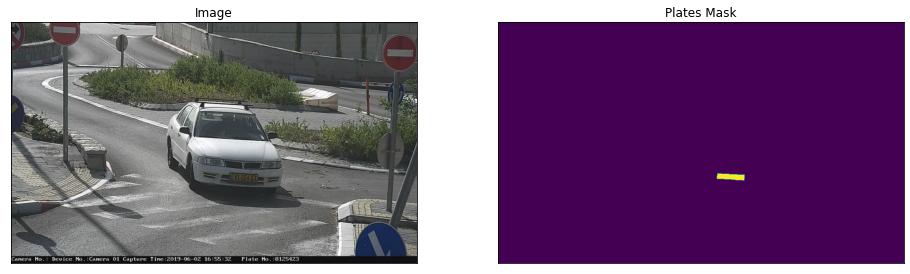

(3, 576, 1024) (1, 576, 1024)


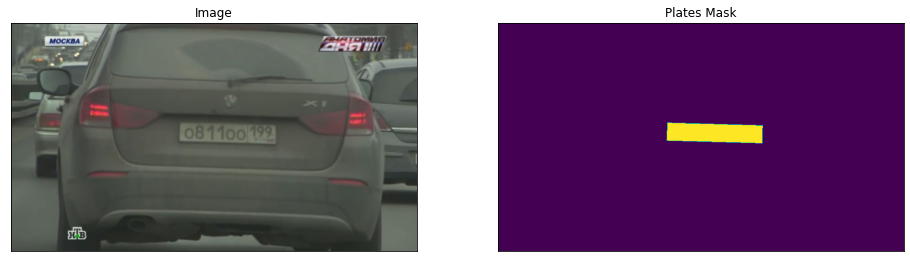

(3, 608, 1024) (1, 608, 1024)


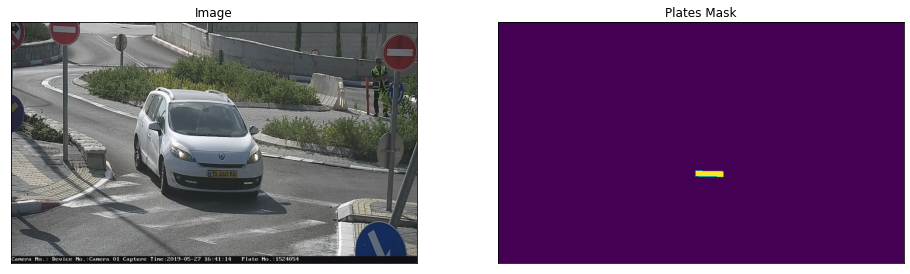

(3, 608, 1024) (1, 608, 1024)


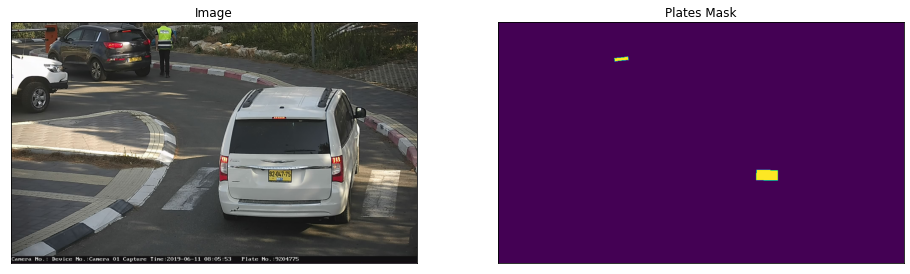

(3, 608, 1024) (1, 608, 1024)


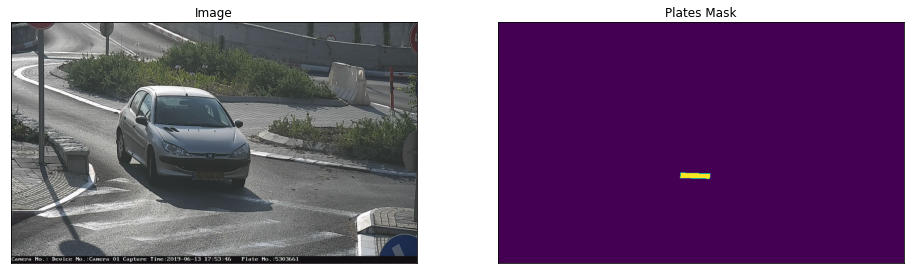

In [20]:
# Lets look at data we have

dataset = DefectsDataset(DATA_DIR, classes=['plates'])
print(f"{len(dataset)} images in the dataset")

for i in range(5):
    input_dict = dataset[i]
    # print(input_dict)
    image, mask = input_dict['image'], input_dict['mask'] # get some sample
    print(image.shape, mask.shape)
    image = image.transpose(1, 2, 0)
    mask = mask.transpose(1, 2, 0)
    visualize(
        image=image, 
        plates_mask=mask.squeeze(),
    )

In [21]:
def get_training_augmentation():
    train_transform = [

        # albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.OneOf(
            [
                albu.RandomCrop(height=480, width=480, p=0.1),
                albu.CropNonEmptyMaskIfExists(height=480, width=480, p=0.9)
            ],
            p=1.0,
        ),
        

        # albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        # albu.OneOf(
        #     [
        #         albu.Sharpen(p=1),
        #         # albu.Blur(p=1),
        #         albu.MotionBlur(blur_limit=5, p=1),
        #         albu.Defocus(radius=4, p=1)
        #     ],
        #     p=0.1,
        # ),

        # albu.OneOf(
        #     [
        #         # albu.CLAHE(p=1),
        #         albu.RandomGamma(p=1),
        #         albu.RandomBrightnessContrast(p=1),
        #         albu.HueSaturationValue(p=1),
        #     ],
        #     p=0.5,
        # ),
    ]
    return albu.Compose(train_transform)

In [22]:
# #### Visualize resulted augmented images and masks

# augmented_dataset = DefectsDataset(
#     DATA_DIR, 
#     augmentation=get_training_augmentation(), 
#     classes=['plates'],
# )

# # same image with different random transforms
# for i in range(5):
#     input_dict = augmented_dataset[3]
#     image, mask = input_dict['image'], input_dict['mask'] # get some sample
#     print(image.shape, mask.shape)
#     image = image.transpose(1, 2, 0)
#     mask = mask.transpose(1, 2, 0)
#     visualize(
#         image=image, 
#         plates_mask=mask.squeeze(),
#     )

In [23]:
classes = ['plates']
# augment = True
augment = False
if augment:
    augmentations = get_training_augmentation()
else:
    augmentations = None
train_dataset = DefectsDataset(
    DATA_DIR, 
    augmentation=augmentations, 
    classes=classes,
)
valid_dataset = DefectsDataset(
    DATA_DIR, 
    augmentation=augmentations, 
    classes=classes,
)
test_dataset = DefectsDataset(
    DATA_DIR, 
    augmentation=None, 
    classes=classes,
)

# split the dataset in train and test set
torch.manual_seed(1)
valid_start = int(len(train_dataset) * 0.7)
test_start = int(len(train_dataset) * 0.9)
print(f"0 : {valid_start} : {test_start} : {len(train_dataset)}")
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[: valid_start])
valid_dataset = torch.utils.data.Subset(valid_dataset, indices[valid_start: test_start])
test_dataset = torch.utils.data.Subset(test_dataset, indices[test_start: ])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

0 : 2610 : 3356 : 3729


In [24]:
class DefectsModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, loss, lr=0.0001, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer('std', torch.tensor(params['std']).view(1, 3, 1, 1))
        self.register_buffer('mean', torch.tensor(params['mean']).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_mode = smp.losses.BINARY_MODE if out_classes == 1 else smp.losses.MULTILABEL_MODE
        self.metrics_mode = 'binary' if out_classes == 1 else 'multilabel'
        
        if loss == 'DiceLoss':
            self.loss_fn = smp.losses.DiceLoss(self.loss_mode, from_logits=True)
        elif loss == 'FocalLoss':
            self.loss_fn = smp.losses.FocalLoss(self.loss_mode)
        elif loss == 'JaccardLoss':
            self.loss_fn = smp.losses.JaccardLoss(self.loss_mode, from_logits=True)
        else:
            raise Exception("Unsupported loss")

        self.lr = lr

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch['image']

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch['mask']

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        prob_mask = logits_mask.sigmoid()
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set
        loss = self.loss_fn(logits_mask, mask)
        self.log(f"{stage}_loss", loss)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode=self.metrics_mode)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'train_loss'}
        # return optimizer

In [28]:
model_name = 'Unet'
encoder_name = 'se_resnext50_32x4d'
out_classes = len(classes)
loss = 'JaccardLoss'
model = DefectsModel(model_name, encoder_name, in_channels=3, out_classes=out_classes, loss=loss)
save_name = f"lprcrop192_lightning_{model_name}_{encoder_name}_c={out_classes}_aug={augment}_{loss}"

In [29]:
loss_checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/Colab Notebooks/weights/lightning/", 
                              filename=f"{save_name}_loss", 
                              save_top_k=1, monitor="valid_loss", mode="min")
iou_checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/Colab Notebooks/weights/lightning/", 
                              filename=f"{save_name}_iou", 
                              save_top_k=1, monitor="valid_dataset_iou", mode="max")
epoch_checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/Colab Notebooks/weights/lightning/", 
                              filename=f"{save_name}_epoch", 
                              save_top_k=1, monitor="epoch", mode="max")

tb_logger = TensorBoardLogger("/content/drive/MyDrive/Colab Notebooks/weights/lightning/tb_logs", 
                              name=f"{save_name}")

trainer = pl.Trainer(
    # accelerator='cpu', 
    accelerator='gpu',
    devices=1, 
    max_epochs=200,
    default_root_dir="/content/drive/MyDrive/Colab Notebooks/weights/lightning/",
    callbacks=[loss_checkpoint_callback, iou_checkpoint_callback, epoch_checkpoint_callback, 
               RichProgressBar(leave=True), LearningRateMonitor('epoch')],
    logger=tb_logger,
    log_every_n_steps=20,
    # auto_lr_find=True,
    accumulate_grad_batches=8 // batch_size
)

# trainer.tune(model, 
#              train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# file_name = "lprcrop192_lightning_Unet_se_resnext50_32x4d_c=1_aug=False_JaccardLoss_epoch.ckpt"
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
    # ckpt_path=f"/content/drive/MyDrive/Colab Notebooks/weights/lightning/{file_name}",
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/weights/lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model   │ FPN         │ 28.1 M │
│ 1 │ loss_fn │ JaccardLoss │      0 │
└───┴─────────┴─────────────┴────────┘

Trainable params: 28.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.1 M                                                                                               
Total estimated model params size (MB): 112

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [ ]:
%tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/weights/lightning/tb_logs"

In [30]:
def decode_file_name(file_name):
    """
    Decodes parameters from a checkpoint file_name.
    """
    args = file_name.split('_')
    model_name = args[2]
    if args[3] == 'se':
        encoder_name = f"{args[3]}_{args[4]}_{args[5]}"
    else:
        encoder_name = args[3]
    if args[-3][0] == 'a':
        augment = True if args[-3][4] == 'T' else False
        out_classes = int(args[-4][-1])
    else:
        augment = False
        out_classes = int(args[-3][-1])
    loss = args[-2]

    return model_name, encoder_name, augment, out_classes, loss

file_name = "lpr_lightning_Unet_se_resnext50_32x4d_c=1_aug=True_JaccardLoss_iou-0.9691.ckpt"
model_name, encoder_name, augment, out_classes, loss = decode_file_name(file_name)
print(model_name, encoder_name, out_classes, augment, loss)
best_model = DefectsModel.load_from_checkpoint(
    f"/content/drive/MyDrive/Colab Notebooks/weights/lightning/{file_name}",
    arch=model_name, encoder_name=encoder_name, in_channels=3, out_classes=out_classes, loss=loss)
valid_metrics = trainer.test(best_model, dataloaders=valid_loader, verbose=False)
test_metrics = trainer.test(best_model, dataloaders=test_loader, verbose=False)
print(f"Validation: {valid_metrics}")
print(f"Test: {test_metrics}")

Unet se_resnext50_32x4d 1 True JaccardLoss


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.5.post0 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file drive/MyDrive/Colab Notebooks/weights/lightning/lpr_lightning_Unet_se_resnext50_32x4d_c=1_aug=True_JaccardLoss_iou-0.9691.ckpt`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Validation: [{'test_loss': 0.05491942912340164, 'test_per_image_iou': 0.945540726184845, 'test_dataset_iou': 0.969950258731842}]
Test: [{'test_loss': 0.050432346761226654, 'test_per_image_iou': 0.9499987959861755, 'test_dataset_iou': 0.9698643684387207}]


In [31]:
best_model = best_model.model

In [32]:
# best_model = torch.load('/content/drive/MyDrive/Colab Notebooks/weights/unet_resnet_defects_06.pth')
# print(best_model)
# encoder_name = "se_resnext50_32x4d"

In [34]:
DEVICE = 'cuda'
# DEVICE = 'cpu'
params = smp.encoders.get_preprocessing_params(encoder_name)
std = torch.tensor(params['std']).view(1, 3, 1, 1).to(DEVICE)
mean = torch.tensor(params['mean']).view(1, 3, 1, 1).to(DEVICE)
best_model.to(DEVICE)

best_model.eval()
with torch.no_grad():
  for i in range(20, 40):
      input_dict = test_dataset[i]
      image, gt_mask = input_dict['image'], input_dict['mask']

      gt_mask = gt_mask.squeeze()

      x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      x_tensor = (x_tensor - mean) / std
      pr_mask = best_model(x_tensor).sigmoid()
      pr_mask = pr_mask.squeeze().cpu().numpy()
      pr_mask = pr_mask > 0.5
          
      image = image.transpose(1, 2, 0)
      image *= 255.0
      image = image.astype(np.uint8)
      print(image.shape, gt_mask.shape, pr_mask.shape)
      visualize(
          image=image, 
          ground_truth_plates=gt_mask, 
          predicted_plates=pr_mask,
      )

Output hidden; open in https://colab.research.google.com to view.